# Sobol' sensitivity indices from chaos

In this example we are going to compute global sensitivity indices from a functional chaos decomposition.

We study the Borehole function that models water flow through a borehole:

$$\frac{2 \pi T_u (H_u - H_l)}{\ln{r/r_w}(1+\frac{2 L T_u}{\ln(r/r_w) r^2_w K_w}\frac{T_u}{T_l})}$$

With parameters:
 
- $r_w$: radius of borehole (m)
- $r$: radius of influence (m)
- $T_u$: transmissivity of upper aquifer ($m^2/yr$)
- $H_u$: potentiometric head of upper aquifer (m)
- $T_l$: transmissivity of lower aquifer ($m^2/yr$)
- $H_l$: potentiometric head of lower aquifer (m)
- $L$: length of borehole (m)
- $K_w$: hydraulic conductivity of borehole ($m/yr$)

In [2]:
from __future__ import print_function
import openturns as ot
from operator import itemgetter 

In [3]:
# borehole model
dimension = 8
input_names = ['rw', 'r', 'Tu', 'Hu', 'Tl', 'Hl', 'L', 'Kw']
model = ot.SymbolicFunction(input_names,
                            ['(2*pi_*Tu*(Hu-Hl))/(ln(r/rw)*(1+(2*L*Tu)/(ln(r/rw)*rw^2*Kw)+Tu/Tl))'])
coll = [ot.Normal(0.1, 0.0161812),
         ot.LogNormal(7.71, 1.0056),
         ot.Uniform(63070.0, 115600.0),
         ot.Uniform(990.0, 1110.0),
         ot.Uniform(63.1, 116.0),
         ot.Uniform(700.0, 820.0),
         ot.Uniform(1120.0, 1680.0),
         ot.Uniform(9855.0, 12045.0)]
distribution = ot.ComposedDistribution(coll)
distribution.setDescription(input_names)

In [4]:
# Freeze r, Tu, Tl from model to go faster
selection = [1,2,4]
complement = ot.Indices(selection).complement(dimension)
distribution = distribution.getMarginal(complement)
model = ot.ParametricFunction(model, selection, distribution.getMarginal(selection).getMean())
input_names_copy = list(input_names)
input_names = itemgetter(*complement)(input_names)
dimension = len(complement)

In [5]:
# design of experiment
size = 1000
X = distribution.getSample(size)
Y = model(X)

In [6]:
# create a functional chaos model
algo = ot.FunctionalChaosAlgorithm(X, Y)
algo.run()
result = algo.getResult()
print(result.getResiduals())
print(result.getRelativeErrors())

[0.0205653]
[7.19232e-07]


In [7]:
# Quick summary of sensitivity analysis
sensitivityAnalysis = ot.FunctionalChaosSobolIndices(result)
print(sensitivityAnalysis.summary())

 input dimension: 5
 output dimension: 1
 basis size: 40
 mean: [73.9426]
 std-dev: [28.0411]
------------------------------------------------------------
Index   | Multi-indice                  | Part of variance  
------------------------------------------------------------
      1 | [1,0,0,0,0]                   | 0.655359
      2 | [0,1,0,0,0]                   | 0.0946395
      4 | [0,0,0,1,0]                   | 0.0930073
      3 | [0,0,1,0,0]                   | 0.0927474
      5 | [0,0,0,0,1]                   | 0.0226136
------------------------------------------------------------


------------------------------------------------------------
Component | Sobol index            | Sobol total index      
------------------------------------------------------------
        0 | 0.662486               | 0.692338              
        1 | 0.0946545              | 0.105777              
        2 | 0.0927636              | 0.103943              
        3 | 0.0940617              | 0

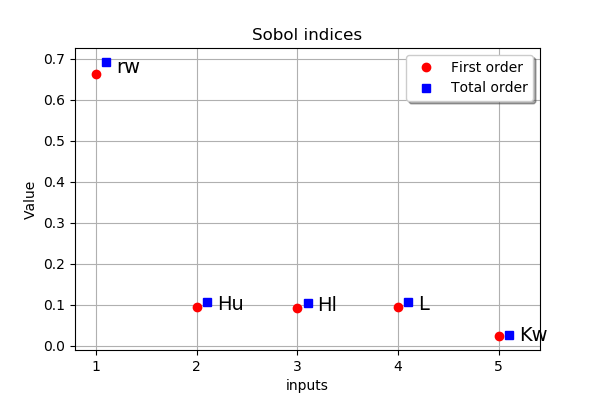

In [10]:
# draw Sobol' indices
first_order = [sensitivityAnalysis.getSobolIndex(i) for i in range(dimension)]
total_order = [sensitivityAnalysis.getSobolTotalIndex(i) for i in range(dimension)]

graph = ot.Graph('Sobol indices', 'inputs', 'Value', True, '')
data = ot.Sample(dimension, 2)
for i in range(dimension):
    data[i, 0] = i+1
    data[i, 1] = first_order[i]
cloud = ot.Cloud(data, "red", "circle", "First order")
graph.add(cloud)
for i in range(dimension):
    data[i, 0] = i+1+0.1
    data[i, 1] = total_order[i]
cloud = ot.Cloud(data, "blue", "square", "Total order")
graph.add(cloud)
for i in range(dimension):
    data[i, 0] = i+1+0.2
    data[i, 1] = 0.5*(first_order[i]+total_order[i])
text = ot.Text(data, input_names, 'right')
text.setColor('black')
graph.add(text)
graph.setLegendPosition("topright")
graph

In [9]:
# We saw that total order indices are close to first order,
# so the higher order indices must be all quite close to 0
for i in range(dimension):
    for j in range(i):
        print(input_names[i] + ' & '+ input_names[j], ":", sensitivityAnalysis.getSobolIndex([i, j]))

Hu & rw : 0.009536222712892008
Hl & rw : 0.009530629479565667
Hl & Hu : 1.3936259801171157e-05
L & rw : 0.008923015390024751
L & Hu : 0.0012697543282222151
L & Hl : 0.0012905102200038215
Kw & rw : 0.0018622904639265824
Kw & Hu : 0.000302490552292122
Kw & Hl : 0.0003439993123678421
Kw & L : 0.00034753666470284497
